This notebook follows from the notebook `grib_test__FOR_0125_dataset_(local_temp_inspection).ipynb`. This notebook extends the local-inspection to a sample of points from grid-sampling.

In [1]:
import pygrib
msgs = pygrib.open(r"C:\SUSTech\datasets_of_graduation_project\0220.grib")

## Grid-sampling
Given the lat-lon range (a rectangular region) of the dataset, the grid-sampling is to uniformly sample points from it.

In [14]:
LAT_RANGE = (90, 66.5) # the entire map is from 90 degree to 66.5 degree, closed interval
LON_RANGE = (-180, 179.5)

In [15]:
LAT_RESOL = 5 # the grid resolution of latitudes; two distinct lats are differred by 5 degrees
LON_RESOL = 30
LAT_VICINITY_R = 1 # Consider the average of the vicinity of each grid point, to reduce the noise. The radius of the vicinity is 1 degree here. This value should not exceed LAT_RESOL
LON_VICINITY_R = 1

In [16]:
LON_shift = 0 # take the (-180 + LON_shift)° as the starting longitude

In [17]:
DISTINCT_LATS = [90 - i * LAT_RESOL 
    for i in range(int((abs(LAT_RANGE[1] - LAT_RANGE[0]) // LAT_RESOL) + 1))] # round down when sampling points
DISTINCT_LONS = [LON_shift + (-180) + i * LON_RESOL 
    for i in range(int((abs(LON_RANGE[1] - LON_RANGE[0]) // LON_RESOL) + 1))]

In [6]:
import numpy as np
from bidict import bidict
msg = msgs[1]

# (lat, lon) -> (lat_idx, lon_idx)
latlon_to_latlonIdx = bidict()
for lat in DISTINCT_LATS:
    for lon in DISTINCT_LONS:
        latlon_to_latlonIdx[(lat, lon)] = (np.where(msg["distinctLatitudes"] == lat)[0][0], 
                                     np.where(msg["distinctLongitudes"] == lon)[0][0])

print(latlon_to_latlonIdx)

# (lat_idx, lon_idx) -> ((lat1_idx, lat2_idx), (lon1_idx, lon2_idx)), 
# with lat1_idx <= lat2_idx, lon1_idx <= lon2_idx
latlonIdx_to_vicinityIdx = bidict()
for latlonIdx in latlon_to_latlonIdx.values():
    lat_idx, lon_idx = latlonIdx
    lat1_idx = int(max(0, 
                lat_idx - LAT_VICINITY_R // 0.25))
    lat2_idx = int(min(len(msg["distinctLatitudes"]), 
                lat_idx + LAT_VICINITY_R // 0.25 + 1))
    lon1_idx = int(max(0, 
                lon_idx - LON_VICINITY_R // 0.25))
    lon2_idx = int(min(len(msg["distinctLongitudes"]), 
                lon_idx + LON_VICINITY_R // 0.25 + 1))
    latlonIdx_to_vicinityIdx[latlonIdx] = ((lat1_idx, lat2_idx), (lon1_idx, lon2_idx))
    
print(latlonIdx_to_vicinityIdx)


bidict({(90, -165): (0, 60), (90, -135): (0, 180), (90, -105): (0, 300), (90, -75): (0, 420), (90, -45): (0, 540), (90, -15): (0, 660), (90, 15): (0, 780), (90, 45): (0, 900), (90, 75): (0, 1020), (90, 105): (0, 1140), (90, 135): (0, 1260), (90, 165): (0, 1380), (85, -165): (20, 60), (85, -135): (20, 180), (85, -105): (20, 300), (85, -75): (20, 420), (85, -45): (20, 540), (85, -15): (20, 660), (85, 15): (20, 780), (85, 45): (20, 900), (85, 75): (20, 1020), (85, 105): (20, 1140), (85, 135): (20, 1260), (85, 165): (20, 1380), (80, -165): (40, 60), (80, -135): (40, 180), (80, -105): (40, 300), (80, -75): (40, 420), (80, -45): (40, 540), (80, -15): (40, 660), (80, 15): (40, 780), (80, 45): (40, 900), (80, 75): (40, 1020), (80, 105): (40, 1140), (80, 135): (40, 1260), (80, 165): (40, 1380), (75, -165): (60, 60), (75, -135): (60, 180), (75, -105): (60, 300), (75, -75): (60, 420), (75, -45): (60, 540), (75, -15): (60, 660), (75, 15): (60, 780), (75, 45): (60, 900), (75, 75): (60, 1020), (75, 

## Compute the `ts_2mTemp` for local inspection

In [ ]:
# # delete `msg` if it is a variable
# if "msg" in locals(): del msg 

# ts_2mTemp = dict()
# for (lat, lon) in latlon_to_latlonIdx.keys(): 
#     msgs.rewind()
#     lat1_idx, lat2_idx = latlonIdx_to_vicinityIdx[latlon_to_latlonIdx[(lat, lon)]][0]
#     lon1_idx, lon2_idx = latlonIdx_to_vicinityIdx[latlon_to_latlonIdx[(lat, lon)]][1]
#     ts_2mTemp[(lat, lon)] = np.array([np.mean(msg["values"][lat1_idx:lat2_idx, lon1_idx:lon2_idx]) for msg in msgs])

In [8]:
from concurrent.futures import ThreadPoolExecutor

if "msg" in locals(): del msg
ts_2mTemp = dict()
for (lat, lon) in latlon_to_latlonIdx.keys():
    ts_2mTemp[(lat, lon)] = np.array([])

def compute_avg_for_latlon(latlon, msg):
    lat, lon = latlon
    lat1_idx, lat2_idx = latlonIdx_to_vicinityIdx[latlon_to_latlonIdx[(lat, lon)]][0]
    lon1_idx, lon2_idx = latlonIdx_to_vicinityIdx[latlon_to_latlonIdx[(lat, lon)]][1]
    
    # 计算该区域的平均值
    avg_value = np.mean(msg["values"][lat1_idx:lat2_idx, lon1_idx:lon2_idx])
    
    # 将计算结果直接存入ts_2mTemp字典
    ts_2mTemp[(lat, lon)] = np.append(ts_2mTemp[(lat, lon)], avg_value)

def compute_avg_for_msg(msg):
    # 使用线程池来并行计算每个msg的所有(lat, lon)的平均值，并直接更新ts_2mTemp
    with ThreadPoolExecutor() as executor:
        # 对每个经纬度对进行并行处理
        futures = [executor.submit(compute_avg_for_latlon, latlon, msg) 
                   for latlon in latlon_to_latlonIdx.keys()]
        
        # 等待所有任务完成
        for future in futures:
            future.result()  # 这个步骤确保每个计算任务完成
    

msgs.rewind()

from tqdm import tqdm
for msg in tqdm(msgs, desc="Processing msgs", unit="msg"):
    compute_avg_for_msg(msg)

Processing msgs: 114720msg [17:21:10,  1.84msg/s] 


In [9]:
# msgs_len = sum(1 for _ in msgs)
# msgs_len

In [10]:
# import numpy as np
# import concurrent.futures

# if "msg" in locals(): del msg

# def process_latlon(lat, lon):
#     lat1_idx, lat2_idx = latlonIdx_to_vicinityIdx[latlon_to_latlonIdx[(lat, lon)]][0]
#     lon1_idx, lon2_idx = latlonIdx_to_vicinityIdx[latlon_to_latlonIdx[(lat, lon)]][1]
#     return (lat, lon, np.array([np.mean(msgs[t]["values"][lat1_idx:lat2_idx, lon1_idx:lon2_idx]) for t in range(1, msgs_len + 1)]))

# def parallel_processing():
#     ts_2mTemp = dict()

#     # 使用 ThreadPoolExecutor 来并行处理
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         futures = [
#             executor.submit(process_latlon, lat, lon)
#             for (lat, lon) in latlon_to_latlonIdx.keys()
#         ]
        
#         for future in concurrent.futures.as_completed(futures):
#             lat, lon, result = future.result()
#             ts_2mTemp[(lat, lon)] = result

#     return ts_2mTemp

# ts_2mTemp = parallel_processing()

In [11]:
msgs.close()

## Save the data

In [ ]:
# print(ts_2mTemp[(80, 60)].shape)

# save the data ts_2mTemp
import h5py
# path = r"outputs\ts_2mTemp_(5_30_1_1_" + str(LON_shift) + ").h5"
path = r"outputs\ts_2mTemp_(5_30_1_1_para).h5"

with h5py.File(path, "w") as f: # (LAT_RESOL, LON_RESOL, LAT_VICINITY_R, LON_VICINITY_R) = (5, 30, 1, 1)
    for key, value in ts_2mTemp.items():
        key_str = f"{key[0]}_{key[1]}"  # convert the keys ((lat, lon) tuples) to strings
        f.create_dataset(key_str, data=value)

In [5]:
# read the data back
import h5py
import numpy as np

path = r"outputs\ts_2mTemp_(5_30_1_1_para).h5"
with h5py.File(path, "r") as f:
    ts_2mTemp_read = {}
    for key in f.keys():
        key_parts = key.split('_')
        key_tuple = (int(key_parts[0]), int(key_parts[1]))
        ts_2mTemp_read[key_tuple] = np.array(f[key])

# check if the data is saved correctly and read correctly
# print(ts_2mTemp_read.keys() == ts_2mTemp.keys())
# print(all([np.array_equal(ts_2mTemp_read[key], ts_2mTemp[key]) for key in ts_2mTemp.keys()]))

## Compute the max-temp time-series

In [6]:
N = 8*15*12 # 8 hours per day, 15 days per month, 12 months per year
N_years = 80 # 1945, 1942, ..., 2024, 80 years in total

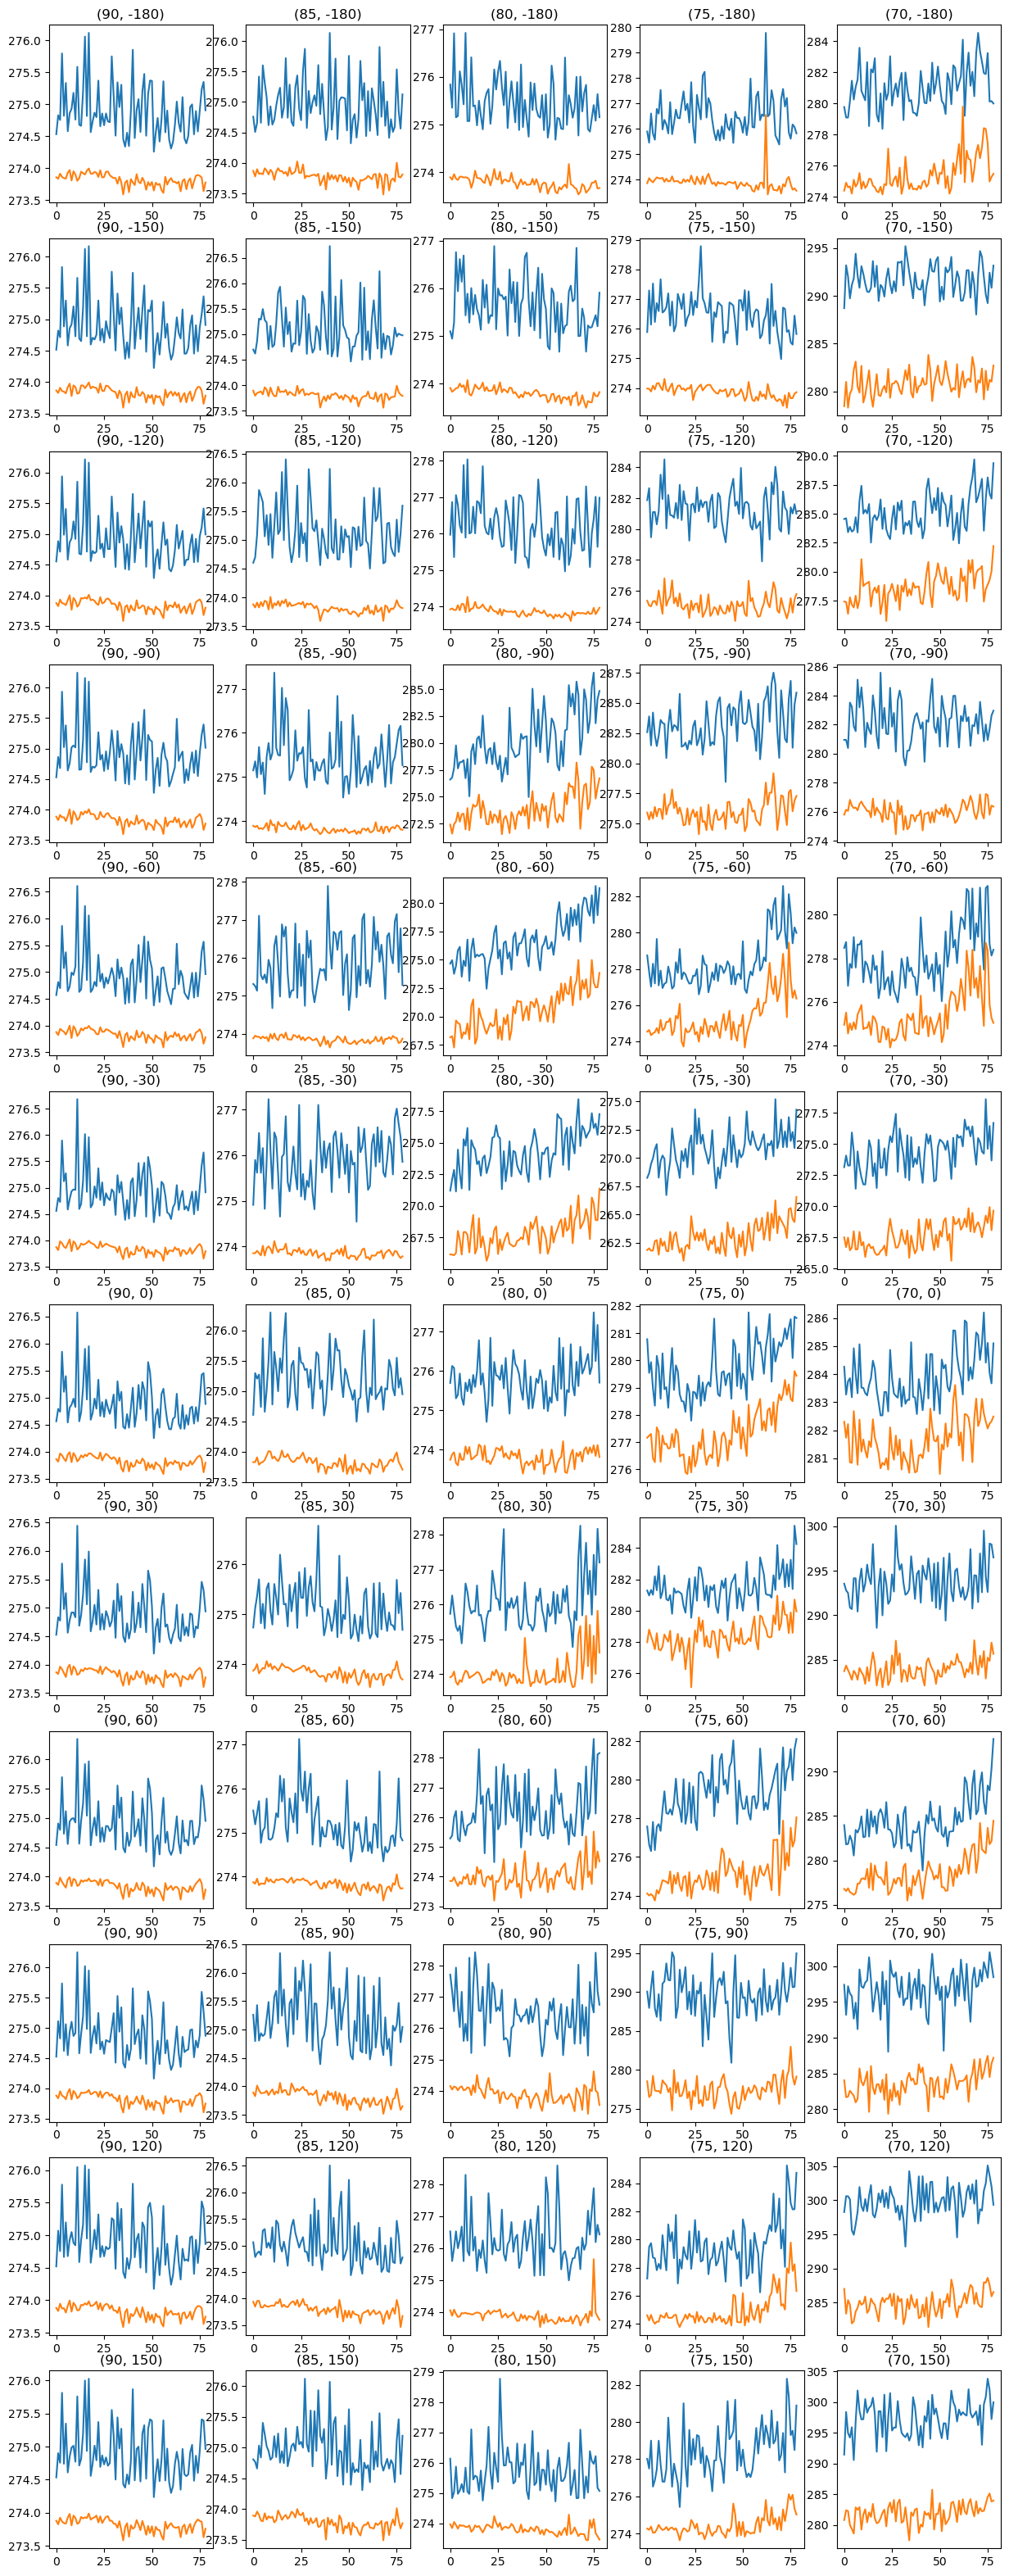

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(DISTINCT_LONS), len(DISTINCT_LATS), figsize=(15, 40))
for i, lon in enumerate(DISTINCT_LONS):
    for j, lat in enumerate(DISTINCT_LATS):
        # maximize the temp over each year 
        ts_annualMax_2mTemp = np.array([ts_2mTemp_read[(lat, lon)][y*N:(y+1)*N].max() 
                                             for y in range(0, N_years-1)])
        # get the 90th percentile of the target temp over each year 
        ts_annual90Percentile_2mTemp = np.array([np.percentile(ts_2mTemp_read[(lat, lon)][y*N:(y+1)*N], 90) 
                                             for y in range(0, N_years-1)])
        ax[i, j].plot(ts_annualMax_2mTemp, label="Max")
        ax[i, j].plot(ts_annual90Percentile_2mTemp, label="90th percentile")
        # ax[i, j].legend()
        ax[i, j].set_title(f"({lat}, {lon})")
        
plt.show()
# fig.savefig(r"outputs\ts_2mTemp_(5_30_1_1_" + str(LON_shift) + ").png")
fig.savefig(r"outputs\ts_2mTemp_(5_30_1_1_para).png")